# Sales Forecasting: Analysis
1. Data sanity check. 
2. Who are the best sales reps?
3. Purchasing trends.


In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [2]:
# load in sales CSV data
orders = pd.read_csv("orders.csv",parse_dates=True)
returns = pd.read_csv("returns.csv",parse_dates=True)
people = pd.read_csv("people.csv",parse_dates=True)


In [57]:
# remove returns from orders dataset
df = (orders
      .merge(right=returns, left_on='Order ID', right_on='Order ID', how='left')
      .merge(right=people, left_on = 'Region', right_on = 'Region', how='left'))

# fill instances when returned is NaN as "NO"
df['Returned'] = df['Returned'].fillna('No')

# remove returned sales orders
df = df[df['Returned'] == 'No']

# convert order date to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# create month and year columns
df['Month'] = df['Order Date'].dt.month
df['Year'] = df['Order Date'].dt.year
df['Period'] = df.Year.astype(str) + '-' + df.Month.astype(str)

##### 1. Data sanity check.

In [4]:
# decriptive statistics of the data
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit,Month,Year
count,9194.000000,9194.000000,9194.000000,9194.000000,9194.000000,9194.000000,9194.000000,9194.000000
mean,5014.685665,53877.041005,230.225863,3.787253,0.157315,28.623522,7.793887,2015.717207
std,2879.842782,31793.373920,623.570060,2.224725,0.207158,228.173572,3.282295,1.123057
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000,1.000000,2014.000000
25%,2523.250000,22153.000000,16.777000,2.000000,0.000000,1.670400,5.000000,2015.000000
50%,5001.500000,53209.000000,54.088000,3.000000,0.200000,8.454600,9.000000,2016.000000
75%,7523.750000,85705.000000,209.700000,5.000000,0.200000,29.250850,11.000000,2017.000000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000,12.000000,2017.000000


In [5]:
# number of NaNs in the dataset
df.isna().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
Returned         0
Person           0
Month            0
Year             0
dtype: int64

array([[<AxesSubplot:title={'center':'Row ID'}>,
        <AxesSubplot:title={'center':'Order Date'}>,
        <AxesSubplot:title={'center':'Postal Code'}>],
       [<AxesSubplot:title={'center':'Sales'}>,
        <AxesSubplot:title={'center':'Quantity'}>,
        <AxesSubplot:title={'center':'Discount'}>],
       [<AxesSubplot:title={'center':'Profit'}>,
        <AxesSubplot:title={'center':'Month'}>,
        <AxesSubplot:title={'center':'Year'}>]], dtype=object)

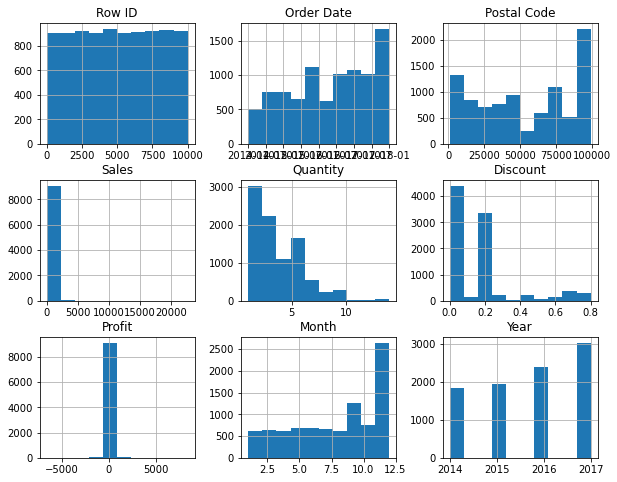

In [6]:
df.hist(figsize=(10, 8))

##### 2. Best sales reps?

In [7]:
# rep sales
rep_sales = df.groupby(['Person']).agg(
    sales = ("Sales","sum"),
    total_orders = ("Sales","count"),
    total_profit = ("Profit","sum")
)

# calculate metrics
rep_sales['mean_amount_per_order'] = rep_sales['sales'] / rep_sales['total_orders']
rep_sales['mean_profit_per_order'] = rep_sales['total_profit'] / rep_sales['total_orders']
rep_sales

,sales,total_orders,total_profit,mean_amount_per_order,mean_profit_per_order
Person,,,,,
Anna Andreadi,617974.7670,2713,88755.0711,227.782811,32.714733
Cassandra Brandow,374412.8080,1551,44530.8198,241.400908,28.711038
Chuck Magee,637076.0960,2699,86537.9794,236.041532,32.062979
Kelly Williams,487232.9114,2231,43340.7899,218.392161,19.426620


Based on the above: 
1. Anna and Chuck generate the most profit per order for the business.
2. Cassandra drives the most in terms of sales amount per order.
3. Depite having a large number of orders, Kelly Williams has low average profit & sales amounts. Possibly due to the type of products that Kelly is selling in comparison to the other 3 reps. Explore this

In [8]:
# investigate why Kelly Williams has lower numbers
reps_sales_by_category = df.groupby(['Person','Category']).agg(
    sales = ("Sales","sum"),
    total_orders = ("Sales","count"),
    total_profit = ("Profit","sum"))

# metrics for most profitable categories
reps_sales_by_category['average_profit'] =  reps_sales_by_category['total_profit'] / reps_sales_by_category['total_orders']

reps_sales_by_category

sales  total_orders  total_profit  \
Person            Category                                                   
Anna Andreadi     Furniture        217736.5990           599     9276.5293   
                  Office Supplies  191401.1390          1598    45158.3603   
                  Technology       208837.0290           516    34320.1815   
Cassandra Brandow Furniture        110779.6100           314     6208.4487   
                  Office Supplies  121067.8120           959    19412.5353   
                  Technology       142565.3860           278    18909.8358   
Chuck Magee       Furniture        194478.4220           570     2918.7156   
                  Office Supplies  197679.8630          1639    38849.0561   
                  Technology       244917.8110           490    44770.2077   
Kelly Williams    Furniture        159785.9894           467    -2293.5395   
                  Office Supplies  160321.2890          1357    12176.9531   
                  Technology       167125.6330           407    33457.3763   

                                   average_profit  
Person            Category                         
Anna Andreadi     Furniture             15.486693  
                  Office Supplies       28.259299  
                  Technology            66.511980  
Cassandra Brandow Furniture             19.772130  
                  Office Supplies       20.242477  
                  Technology            68.020992  
Chuck Magee       Furniture              5.120554  
                  Office Supplies       23.702902  
                  Technology            91.367771  
Kelly Williams    Furniture             -4.911219  
                  Office Supplies        8.973436  
                  Technology            82.204856

The above suggests the following:
1. Furniture is the least profitable product to sell. Technology is the most profitable.
2. Overall, Kelly Williams is least profitable overall because she has low numbers in Office Supplies, and has actually cost the business money in her Furniture sales.


##### 3. Purchasing trends.

<AxesSubplot:title={'center':'Global: Year/Monthly Sales (2014-2017)'}, xlabel='Year,Month,Region'>

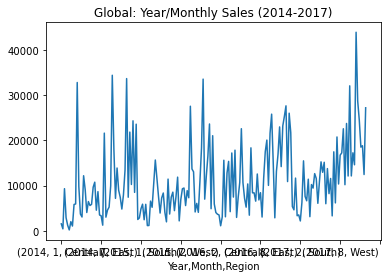

In [37]:
yearly_sales = df.groupby(['Year','Month']).agg(
    total_sales = ("Sales",'sum'),
    total_profit = ("Profit",'sum')
)

# yearly sales
yearly_sales['total_sales'].plot(title='Global: Year/Monthly Sales (2014-2017)')

There is an upward trend in sales since 2014.

<AxesSubplot:title={'center':'Global: Monthly Sales Patterns (Mean 2014-2017)'}, xlabel='Month'>

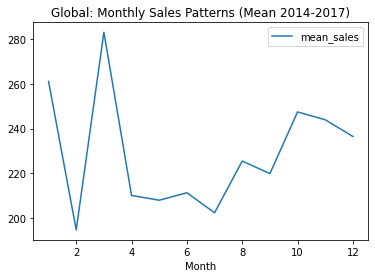

In [10]:
monthly_sales = df.groupby(['Month']).agg(
    mean_sales = ("Sales",'mean')
)
# plot the montly pattern in sales
monthly_sales.plot(title="Global: Monthly Sales Patterns (Mean 2014-2017)")

In [11]:
# Yearly increase in sales/profit
yearly_sales.groupby(['Year']).agg(
    total_sales = ("total_sales","sum"),
    total_profit = ("total_profit",'sum')

).diff()

,total_sales,total_profit
Year,,
2014,NaN,NaN
2015,-24156.3351,8123.2767
2016,142212.2110,21986.2149
2017,84629.3653,-1470.7877


Seems that sales/profit was increasing over time however for 2017 profit decreased slightly. Likely due to Kelly Williams sales.

## Time Series Analysis

In [28]:
# create time series 
ts = yearly_sales.reset_index()
ts['dt'] = pd.to_datetime(ts.Year.astype("str") + "-" + ts.Month.astype("str").str.zfill(2))
ts = ts[['dt','total_sales']].set_index('dt')

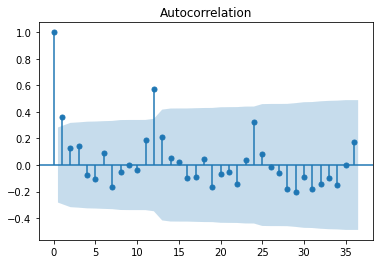

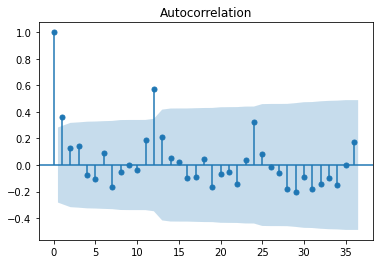

In [58]:
# seasonal 
plot_acf(x=ts['total_sales'].squeeze(), lags=36)


There is some clear seasonality in the data, with significant correlation spikes occuring every 12 months.

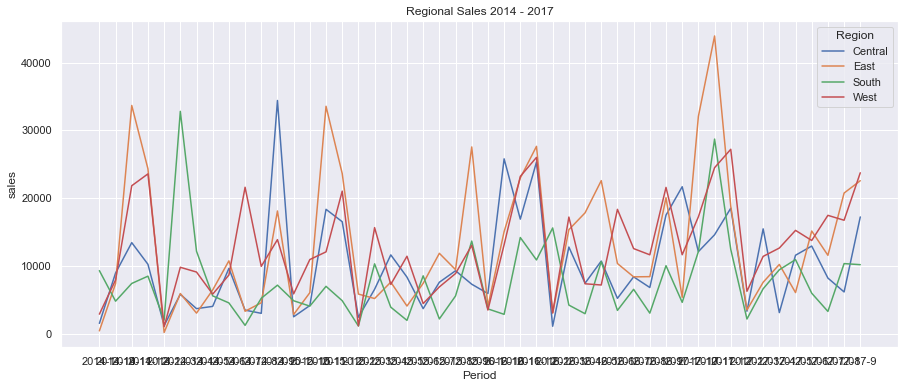

In [68]:
# regional plot of sales since 2014
df_sales_regional = df.groupby(['Region','Period']).agg(sales=('Sales','sum')).reset_index()
fig = sns.lineplot(data = df_sales_regional, x='Period',y='sales',hue='Region')
fig.set_title('Regional Sales 2014 - 2017')
sns.set(rc={'figure.figsize':(15,6)})

